In [ ]:
#%% Import Moduels

## System Tools
import os
import sys
import numpy as np
## I/O Tools
import _pickle as pickle
## Data Process Tools
import pandas as pd
import datetime
## Graphs
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as figpdf
import matplotlib.dates as matdates
## Statistical Tools
import statsmodels.api as sm
import scipy.stats as stats
## Database API
from fredapi import Fred
## API for WRDS
import wrds
import seaborn as sns
import pyfixest as pf
from binsreg import binsreg
# End of Section: Import Moduels
###############################################################################


#%% Setup Working Directory
## Windows System Path
FolderList = [xx+"\\Dropbox\\Research Projects\\02_FirmHete_AsymmetricInformation\\Data\\Micro_data\\codes\\" \
              for xx in ["D:\\", "E:\\","B:\\","/mnt/b/"]]
for Folder in FolderList:
    if os.path.exists(Folder):
        os.chdir(Folder)     

## Output Folder
OutputFolder = '../results/AbReturnDistribution/'
if not os.path.exists(OutputFolder):
    os.makedirs(OutputFolder)
# End of Section: Setup Working Directory
###############################################################################
    

# End of Section: Setup Working Directory
###############################################################################


#%% Import Self-written Functions
CodeFolder      =   "../../../../../Code/PythonLib/"

sys.path.append(CodeFolder)

import Toolkit_TimeSeries as MyTS
import Toolkit_Graphics as MyGR
# End of Section: Import Self-written Functions
###############################################################################




# Construct the sample

## Load in the data

In [ ]:
DataFolder          =   "..\\temp\\"
SDC_AbRet_Wide      =   pd.read_pickle(DataFolder+"SDC_AbRet_Wide.p")
SDC_IssuanceInfo    =   pd.read_pickle(DataFolder+"SDC_IssuanceInfo.p") 

In [ ]:
VarList_AbRet = ['F_AccAbRet_-1_1', 'I_AccAbRet_-1_1']

temp = SDC_AbRet_Wide.loc[:, ['IssueID']+VarList_AbRet]
temp[VarList_AbRet] = temp[VarList_AbRet]*100

In [ ]:
Sample = SDC_IssuanceInfo.merge(temp, how='left', left_on='IssueID', right_on='IssueID')

## Clean the data

In [ ]:
# Measure the price drop differently for firms with different shelf-issuance type 
TempInd = Sample['ShelfIssueFlag']==1

Sample['EventDate'] = Sample['FilingDate']
Sample.loc[TempInd, 'EventDate'] = Sample.loc[TempInd, 'IssueDate']

Sample['AccAbRet'] = Sample['F_AccAbRet_-1_1']
Sample.loc[TempInd, 'AccAbRet'] = Sample.loc[TempInd, 'I_AccAbRet_-1_1']

Sample['EventDate_Quarter'] = Sample['FilingDate_Quarter']
Sample.loc[TempInd, 'EventDate_Quarter'] = Sample.loc[TempInd, 'IssueDate_Quarter']

In [ ]:
# Different measures of issuance 
Sample['LogProceeds'] = np.log(Sample['ProceedsAmount'])
Sample['Proceed_Asset'] = Sample['ProceedsAmount'] / Sample['TotalAsset_BeforeOffering']
Sample['Proceed_Equity'] = Sample['ProceedsAmount'] / Sample['TotalEquity']
Sample['Log_Asset'] = np.log(Sample['TotalAsset_BeforeOffering'])
Sample['Leverage'] = Sample['TotalDebt'] / Sample['TotalAsset_BeforeOffering']
Sample['ExtraShare'] = Sample['OfferedTotalShares']/Sample['TotalShares_BeforeOffering']

d:\Dropbox\Research Projects\02_HeteFirm_AsymetricInformation\Data\Env_Python\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log


In [ ]:
Sample.columns

Index(['IssueID', 'IssueID_ObsNum', 'FilingDate', 'FilingDateFlag',
       'FilingDate_Year', 'FilingDate_Quarter', 'FilingDate_Month',
       'LaunchDate', 'LaunchDateFlag', 'LaunchDate_Year', 'LaunchDate_Quarter',
       'LaunchDate_Month', 'IssueDate', 'IssueDateFlag', 'IssueDate_Year',
       'IssueDate_Quarter', 'IssueDate_Month', 'GapDays_F2I', 'GapDays_L2I',
       'GapDays_F2L', 'GapBusDays_F2I', 'GapBusDays_L2I', 'GapBusDays_F2L',
       'SIC', 'FF5_Name', 'FF5_Code', 'FF10_Name', 'FF10_Code', 'Issuer',
       'Nation', 'Exchange', 'CUSIP', 'CUSIP_9digit', 'CUSIP_1_6', 'CUSIP_7_8',
       'CUSIP_8digit', 'CUSIP_DigitNum', 'TickerSymbol', 'DaysInRegistration',
       'RightsOfferFlag', 'Rule415ShelfFlag', 'ProceedsUse', 'PrincipalAmount',
       'FiledAmount', 'ProceedsAmount', 'RealPrincipalAmount',
       'RealFiledAmount', 'RealProceedsAmount', 'FiledShares',
       'OfferedTotalShares', 'OfferedPrimaryShares', 'OfferedSecondaryShares',
       'OfferAvgPrice', 'OfferedPrimar

In [ ]:
Sample['ShareType'].value_counts()

ShareType
Primary    4147
Combin.    1901
Second.    1882
Name: count, dtype: int64

In [ ]:
Sample['RightsOfferFlag'].value_counts()

RightsOfferFlag
No     7836
Yes      94
Name: count, dtype: int64

<Axes: xlabel='EventDate_Quarter'>

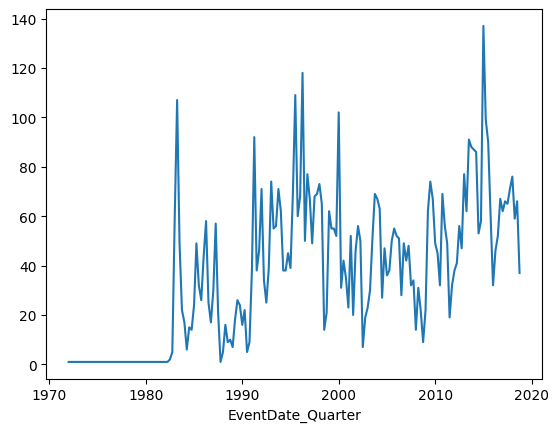

In [ ]:
Sample['EventDate_Quarter'].value_counts().sort_index().plot()

In [ ]:
TempInd_Date = (Sample['EventDate_Quarter'] > datetime.date(1985, 1, 1) ) & (Sample['EventDate_Quarter'] < datetime.date(2019, 1, 1))
TempInd_NaN = np.isfinite(Sample[['Proceed_Asset', 'AccAbRet', 'LogProceeds', 'ExtraShare']]).all(axis=1)

In [ ]:
Sample = Sample.loc[TempInd_Date & TempInd_NaN, :]

# Basic analysis

## Some simple distribution of key variables 

In [ ]:
VarList = ['Proceed_Asset', 'Proceed_Equity', 'ExtraShare', 'AccAbRet']
PctList = [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.999]

In [ ]:
DescStat = Sample[VarList].describe(percentiles=PctList)
DescStat 

,Proceed_Asset,Proceed_Equity,ExtraShare,AccAbRet
count,5597.000000,4365.000000,5597.000000,5597.000000
mean,0.575320,0.485224,11.343494,-2.774354
std,2.993605,1.885823,766.634168,9.473765
min,0.000021,-39.675000,0.000000,-75.747999
0.1%,0.003429,-17.997145,0.000828,-65.301775
0.5%,0.008528,-4.033793,0.006092,-41.920261
1%,0.014253,-1.763302,0.012341,-34.217373
5%,0.036668,0.056348,0.037279,-16.532933
10%,0.054268,0.106071,0.057224,-11.580740
25%,0.114017,0.222416,0.093317,-6.414504


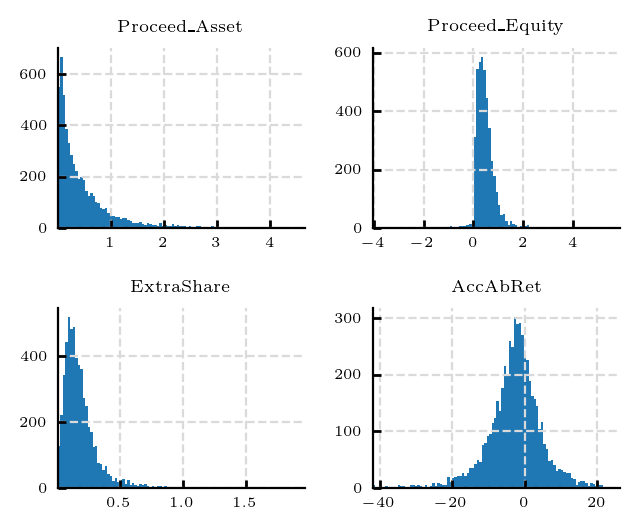

In [ ]:

    
Fig = MyGR.Setup_Fig(FigSize=(1/5 * 2, 1/6 * 2))
for (ii, vv) in enumerate(VarList):
    ax = Fig.add_subplot(2,2,ii+1)
    tempind = (Sample[vv]>DescStat.loc['0.5%', vv]) & (Sample[vv]<DescStat.loc['99.5%', vv])
    Sample.loc[tempind, vv].hist(ax=ax, bins=100)
    ax.set_title(vv, fontsize=6)
    ax.set_xlim(DescStat.loc['0.5%', vv], DescStat.loc['99.5%', vv])
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    MyGR.Setup_Ax(ax)

plt.tight_layout()

## Correlation with the abnormal return

In [ ]:
Flag_Start = True
for vv in VarList:
    if Flag_Start:
        Flag_Start = False
        TempInd_Outliner = (Sample[vv]<DescStat.loc['0.5%', vv]) | (Sample[vv]>DescStat.loc['99.5%', vv])
    else:
        TempInd_Outliner = TempInd_Outliner | (Sample[vv]<DescStat.loc['0.5%', vv]) | (Sample[vv]>DescStat.loc['99.5%', vv])

    

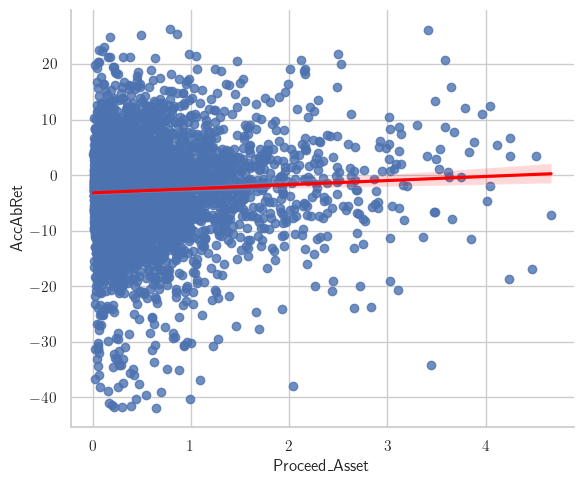

In [ ]:
sns.set(style="whitegrid")
sns.lmplot(x='Proceed_Asset', y='AccAbRet', data=Sample.loc[~TempInd_Outliner, :], ci=95, height=5, aspect=1.2, line_kws={"color": "red"})


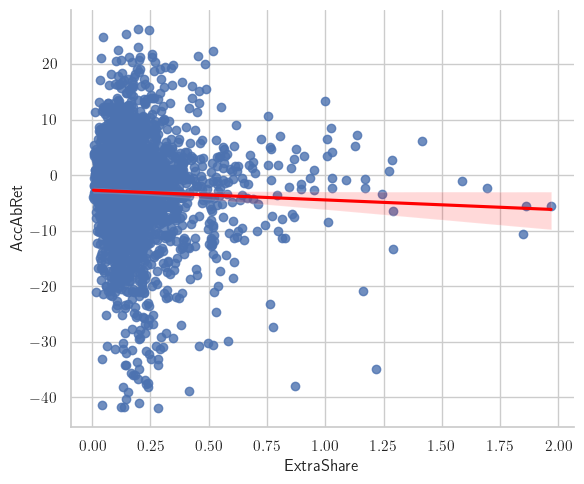

In [ ]:
tempind = (~TempInd_Outliner) & (Sample['ShareType']=='Primary')
sns.lmplot(x='ExtraShare', y='AccAbRet', data=Sample.loc[tempind, :], ci=95, height=5, aspect=1.2, line_kws={"color": "red"})

d:\Dropbox\Research Projects\02_HeteFirm_AsymetricInformation\Data\Env_Python\Lib\site-packages\binsreg\binsreg.py:792: UserWarning: To speed up computation, bin/degree selection uses a subsample of roughly max(5,000, 0.01n) observations if the sample size n>5,000. To use the full sample, set randcut=1.


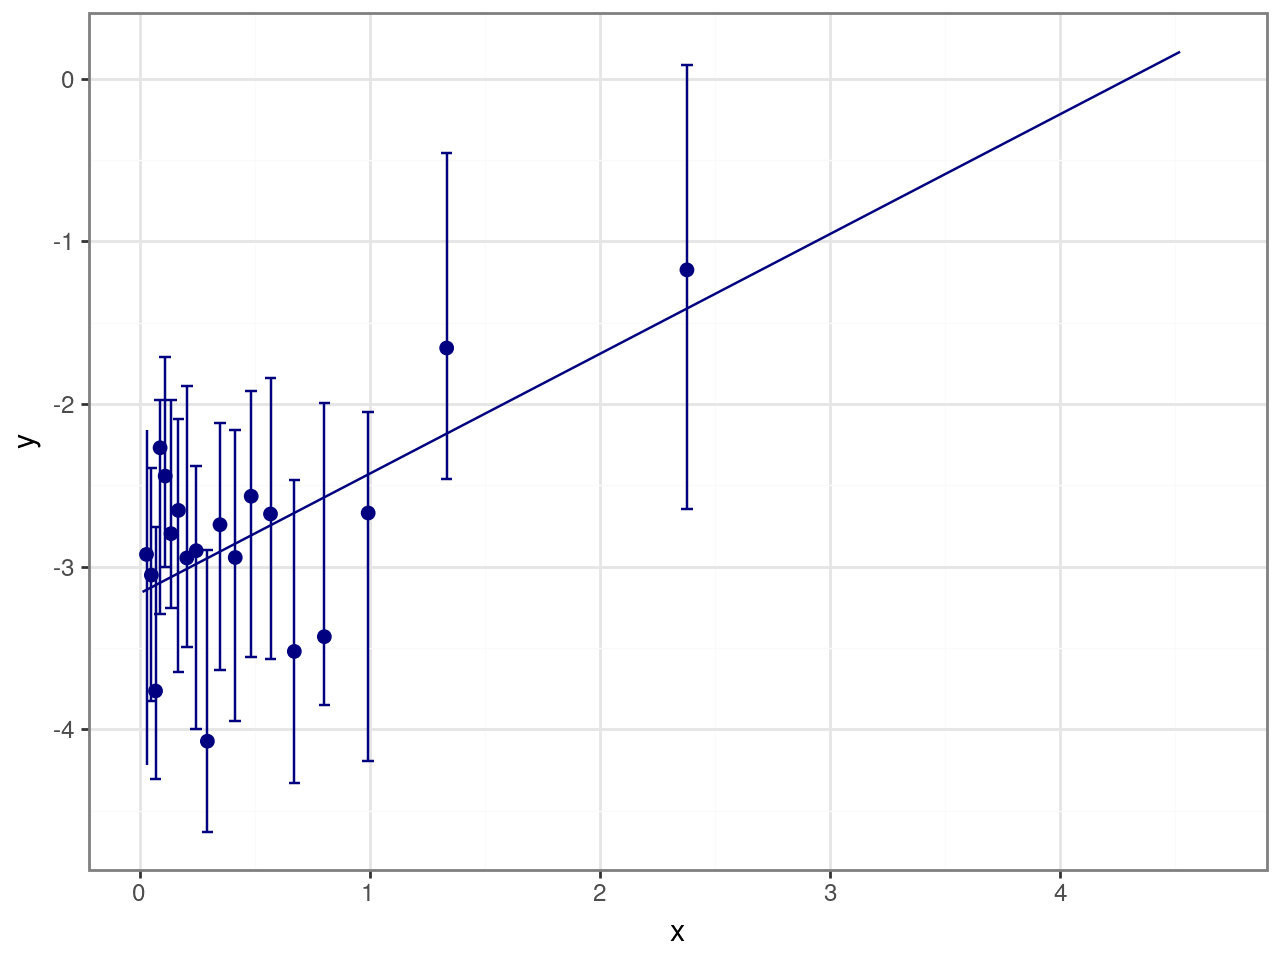

Call: binsreg

Binscatter Plot
Bin/Degree selection method (binsmethod) =  IMSE direct plug-in (select # of bins)
Placement (binspos)                      =                         Quantile-spaced
Derivative (deriv)                       =                                       0
 
Group (by)                               =                             Full Sample
Sample size (n)                          =                                    5398
# of distinct values (Ndist)             =                                    5347
# of clusters (Nclust)                   =                                     nan
dots, degree (p)                         =                                       0
dots, smooth (s)                         =                                       0
# of bins (nbins)                        =                                      19




In [ ]:
binsreg(Sample.loc[~TempInd_Outliner, 'AccAbRet'], Sample.loc[~TempInd_Outliner, 'Proceed_Asset'], ci=(3,3), polyreg=1)

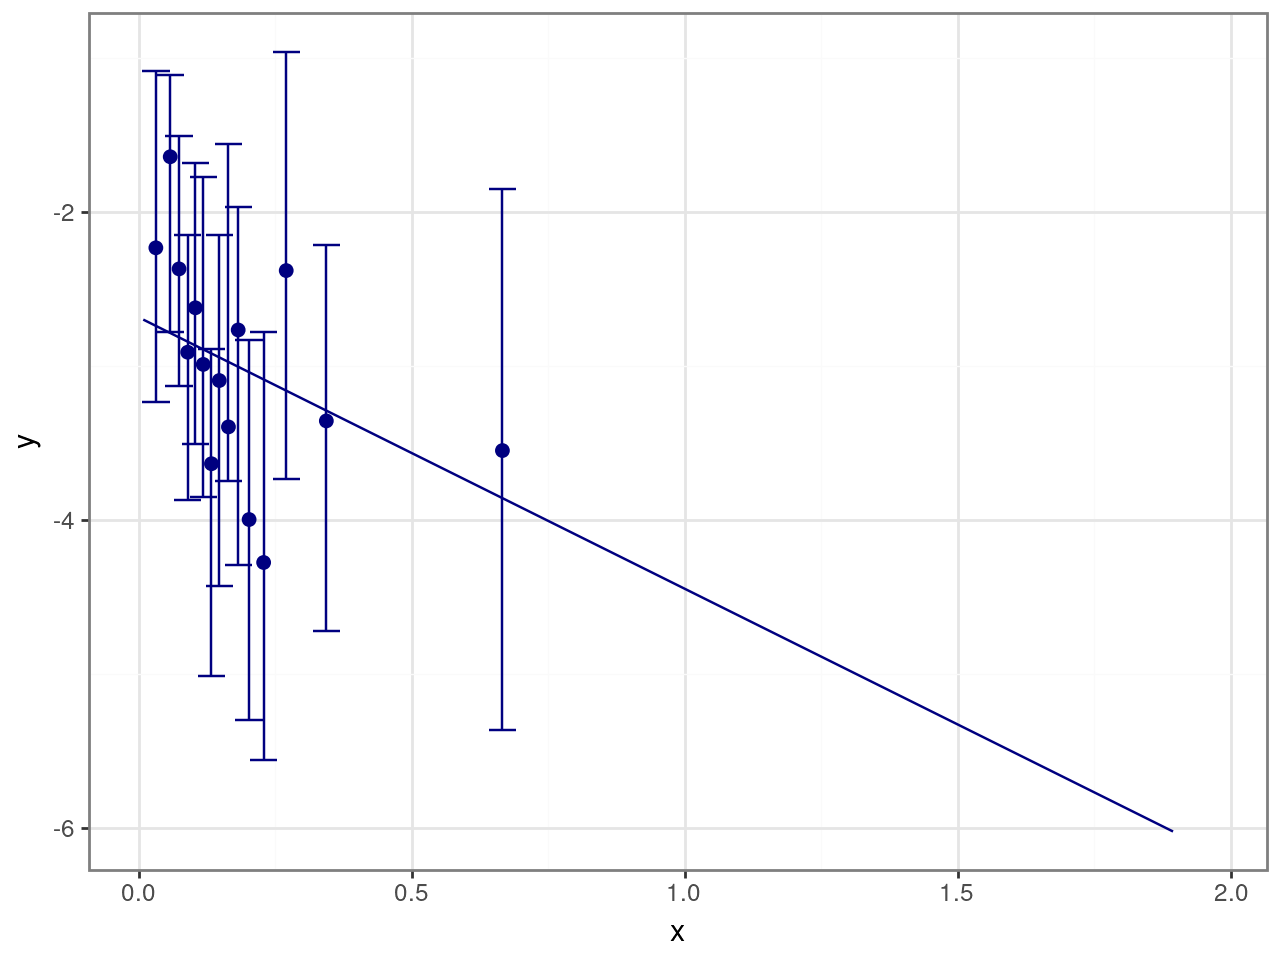

Call: binsreg

Binscatter Plot
Bin/Degree selection method (binsmethod) =  IMSE direct plug-in (select # of bins)
Placement (binspos)                      =                         Quantile-spaced
Derivative (deriv)                       =                                       0
 
Group (by)                               =                             Full Sample
Sample size (n)                          =                                    3005
# of distinct values (Ndist)             =                                    3004
# of clusters (Nclust)                   =                                     nan
dots, degree (p)                         =                                       0
dots, smooth (s)                         =                                       0
# of bins (nbins)                        =                                      15




In [ ]:
tempind = (~TempInd_Outliner) & (Sample['ShareType']=='Primary')
binsreg(Sample.loc[tempind, 'AccAbRet'], Sample.loc[tempind, 'ExtraShare'], ci=(3,3), polyreg=1)

In [ ]:
tempind = (~TempInd_Outliner) & (Sample['ShareType']=='Primary')
fit_AbRet = pf.feols("AccAbRet ~ Log_Asset + Leverage_BeforeOffering | EventDate_Quarter + FF10_Code + ShelfIssueFlag  ", data=Sample.loc[tempind, :])

TempDS = fit_AbRet._data[['IssueID', 'AccAbRet']].copy()
TempDS['AccAbRet_Res'] = fit_AbRet.resid()

TempDS_AbRet = TempDS.copy()

In [ ]:
TempDS[['AccAbRet', 'AccAbRet_Res']].skew()

AccAbRet       -0.587957
AccAbRet_Res   -0.250210
dtype: float64

In [ ]:
tempind = (~TempInd_Outliner) & (Sample['ShareType']=='Primary')
fit_ExtShare = pf.feols("ExtraShare ~ Log_Asset + Leverage_BeforeOffering | EventDate_Quarter + FF10_Code + ShelfIssueFlag  ", data=Sample.loc[tempind, :])

TempDS = fit_ExtShare._data[['IssueID', 'ExtraShare']].copy()
TempDS['ExtraShare_Res'] = fit_ExtShare.resid()

TempDS_ExtShare = TempDS.copy()

array([[<Axes: title={'center': 'ExtraShare'}>,
        <Axes: title={'center': 'ExtraShare_Res'}>]], dtype=object)

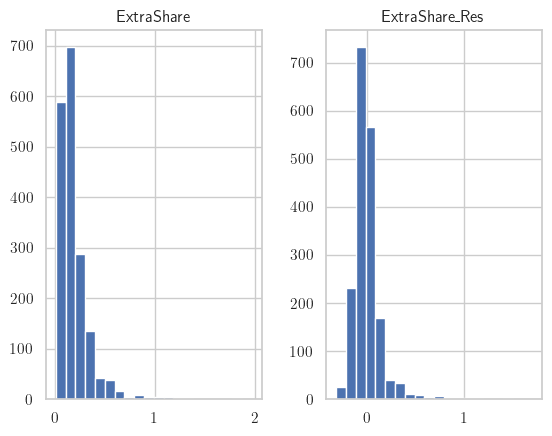

In [ ]:
TempDS[['ExtraShare', 'ExtraShare_Res']].hist(bins=20)

In [ ]:
TempDS = TempDS_AbRet.merge(TempDS_ExtShare, how='outer', on='IssueID')

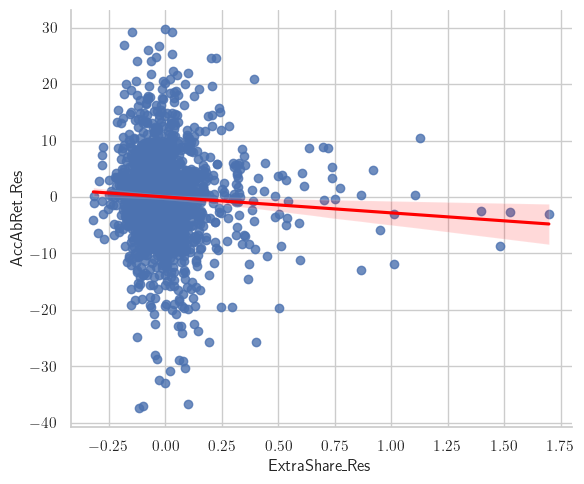

In [ ]:
sns.lmplot(x='ExtraShare_Res', y='AccAbRet_Res', data=TempDS, ci=95, height=5, aspect=1.2, line_kws={"color": "red"}) 

In [ ]:
tempind = (~TempInd_Outliner) & (Sample['ShareType']=='Primary')
fit = pf.feols("AccAbRet ~ ExtraShare + LogProceeds + Log_Asset + Leverage_BeforeOffering | EventDate_Quarter + FF10_Code + ShelfIssueFlag  ", data=Sample.loc[tempind, :])

fit.summary()

###

Estimation:  OLS
Dep. var.: AccAbRet, Fixed effects: EventDate_Quarter+FF10_Code+ShelfIssueFlag
Inference:  CRV1
Observations:  1843

| Coefficient             |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| ExtraShare              |     -3.769 |        1.092 |    -3.452 |      0.001 | -5.929 |  -1.609 |
| LogProceeds             |      1.168 |        0.348 |     3.353 |      0.001 |  0.479 |   1.857 |
| Log_Asset               |     -0.520 |        0.214 |    -2.428 |      0.017 | -0.943 |  -0.096 |
| Leverage_BeforeOffering |     -0.117 |        0.140 |    -0.834 |      0.406 | -0.395 |   0.161 |
---
RMSE: 7.609 R2: 0.114 R2 Within: 0.018 


# Some updated results

## Weighted average across time

In [ ]:
def TempFun_WM(DS,VarList,WeightVar):
    Temp_Num        =   DS[VarList].multiply(DS[WeightVar],axis=0).sum(axis=0)
    Temp_DeNum      =   ( ~pd.isna(DS[VarList]) ).multiply(DS[WeightVar],axis=0).sum(axis=0)
    WM              =   Temp_Num.divide(Temp_DeNum,axis=0)
    WM.name         =   'WMean'
    
    return WM


In [ ]:
tempind = (~TempInd_Outliner) & (Sample['ShareType']=='Primary')
TempSample = Sample.loc[tempind, :].copy()
temp = TempSample.groupby('EventDate_Quarter')['AccAbRet'].mean().rename('AccAbRet_Avg').reset_index()
TempSample = TempSample.merge(temp, how='left', left_on='EventDate_Quarter', right_on='EventDate_Quarter')
temp = TempSample.groupby('EventDate_Quarter')['ExtraShare'].mean().rename('ExtraShare_Avg').reset_index()
TempSample = TempSample.merge(temp, how='left', left_on='EventDate_Quarter', right_on='EventDate_Quarter')

TempSample['Flag_Negative'] = TempSample['AccAbRet'] < 0 
TempSample['Flag_BelowAvg'] = TempSample['AccAbRet'] < TempSample['AccAbRet_Avg']
TempSample['Flag_AboveAvgExtShare'] = TempSample['ExtraShare'] > TempSample['ExtraShare_Avg']

In [ ]:
VarList = ['Proceed_Asset', 'Proceed_Equity', 'ExtraShare', 'AccAbRet']
PctList = [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.999]

In [ ]:
DescStat = TempSample[VarList].describe(percentiles=PctList)
DescStat 

,Proceed_Asset,Proceed_Equity,ExtraShare,AccAbRet
count,3005.000000,2286.000000,3005.000000,3005.000000
mean,0.476800,0.401071,0.187348,-3.012401
std,0.563647,0.481699,0.168548,8.642697
min,0.008530,-3.974874,0.006093,-41.918162
0.1%,0.010765,-3.684803,0.006927,-41.393585
0.5%,0.015450,-1.500053,0.013619,-35.955653
1%,0.019115,-0.918298,0.017492,-31.530031
5%,0.036480,0.066506,0.041081,-17.920610
10%,0.053659,0.105764,0.057793,-13.096749
25%,0.108515,0.195588,0.093107,-7.044741


In [ ]:
TempSample['AccAbRet'].describe()

count    3005.000000
mean       -3.012401
std         8.642697
min       -41.918162
25%        -7.044741
50%        -2.380154
75%         1.808660
max        26.344377
Name: AccAbRet, dtype: float64

<Axes: xlabel='EventDate_Quarter'>

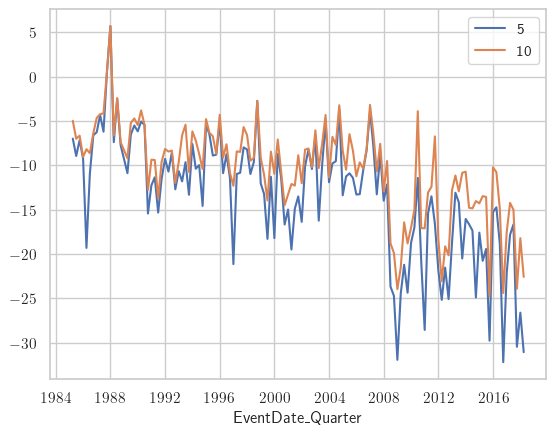

In [ ]:
temp = TempSample.groupby('EventDate_Quarter')['AccAbRet'].describe(percentiles=PctList).sort_index()

temp[['5%', '10%']].plot()

In [ ]:
temp.mean()

count    22.765152
mean     -2.765506
std       7.369697
min     -19.123259
0.1%    -18.985424
0.5%    -18.434085
1%      -17.744911
5%      -13.355299
10%     -10.445787
25%      -6.477083
50%      -2.567804
75%       1.177445
90%       4.808097
95%       7.246516
99%      10.482672
99.5%    10.936087
99.9%    11.298820
max      11.389503
dtype: float64

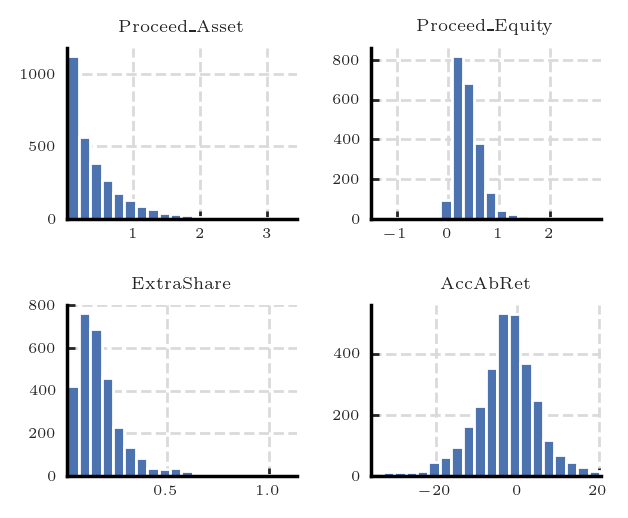

In [ ]:
Fig = MyGR.Setup_Fig(FigSize=(1/5 * 2, 1/6 * 2))
for (ii, vv) in enumerate(VarList):
    ax = Fig.add_subplot(2,2,ii+1)
    tempind = (TempSample[vv]>DescStat.loc['0.5%', vv]) & (TempSample[vv]<DescStat.loc['99.5%', vv])
    TempSample.loc[tempind, vv].hist(ax=ax, bins=20)
    ax.set_title(vv, fontsize=6)
    ax.set_xlim(DescStat.loc['0.5%', vv], DescStat.loc['99.5%', vv])
    MyGR.Setup_Ax(ax)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)

plt.tight_layout()

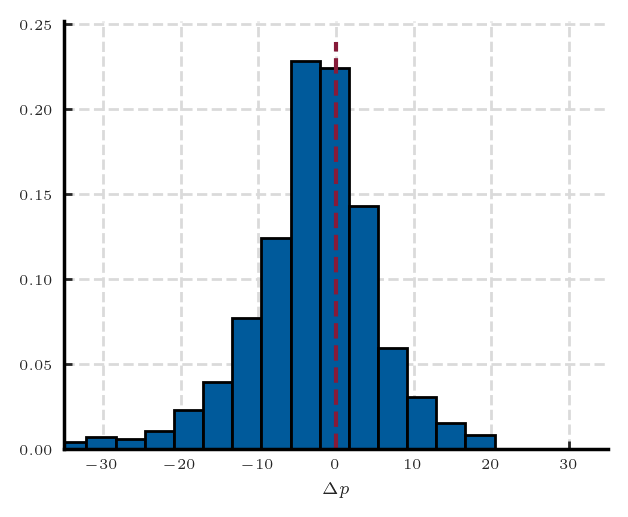

In [ ]:
vv = 'AccAbRet'
Fig = MyGR.Setup_Fig(FigSize=(1/5 * 2, 1/6 * 2))
ax = Fig.add_subplot(1,1,1)
tempind = (TempSample[vv]>DescStat.loc['0.5%', vv]) & (TempSample[vv]<DescStat.loc['99.5%', vv])
# TempSample.loc[tempind, vv].hist(ax=ax, bins=15)
counts, bins = np.histogram(TempSample.loc[tempind, vv], bins=15)
probabilities = counts / counts.sum()
plt.bar(bins[:-1], probabilities, width=np.diff(bins), edgecolor='black', facecolor=MyGR.MyColor('Blue'), align='edge')
ax.vlines(0, 0, ax.get_ylim()[1], color=MyGR.MyColor('Red'), linestyle='--')
ax.set_xlim(-35, 35)
ax.set_xlabel('$\Delta p$', fontsize=6)
# for spine in ax.spines.values():
#     spine.set_color('black')
MyGR.Setup_Ax(ax, XTickNbins=7, YTickNbins=7)
# plt.tick_params(axis='both', length=3, width=1, direction='in', labelsize=5)
plt.tight_layout()

plt.savefig(OutputFolder+'Hist_PriceDropDist_Data.eps', format='eps', dpi=1000)

In [ ]:
DataDict = {}
DataDict['AccAbRet_Avg'] = TempSample.groupby('EventDate_Quarter')['AccAbRet'].mean().sort_index()
DataDict['AccAbRet_WAvg'] = TempSample.groupby('EventDate_Quarter').apply(TempFun_WM, ['AccAbRet'], 'ExtraShare', include_groups=False).sort_index()['AccAbRet'].rename('AccAbRet_WAvg')

DataDict['AccAbRet_Avg_Negative'] = TempSample.loc[TempSample['Flag_Negative'], :].groupby('EventDate_Quarter')['AccAbRet'].mean().sort_index()
DataDict['AccAbRet_WAvg_Negative'] = TempSample.loc[TempSample['Flag_Negative'], :].groupby('EventDate_Quarter').apply(TempFun_WM, ['AccAbRet'], 'ExtraShare', include_groups=False).sort_index()['AccAbRet'].rename('AccAbRet_WAvg_Negative')

DataDict['AccAbRet_Avg_BelowAvg'] = TempSample.loc[TempSample['Flag_BelowAvg'], :].groupby('EventDate_Quarter')['AccAbRet'].mean().sort_index()
DataDict['AccAbRet_WAvg_BelowAvg'] = TempSample.loc[TempSample['Flag_BelowAvg'], :].groupby('EventDate_Quarter').apply(TempFun_WM, ['AccAbRet'], 'ExtraShare', include_groups=False).sort_index()['AccAbRet'].rename('AccAbRet_WAvg_BelowAvg')

DataDict['AccAbRet_Avg_AboveAvgExtShare'] = TempSample.loc[TempSample['Flag_AboveAvgExtShare'], :].groupby('EventDate_Quarter')['AccAbRet'].mean().sort_index()
DataDict['AccAbRet_WAvg_AboveAvgExtShare'] = TempSample.loc[TempSample['Flag_AboveAvgExtShare'], :].groupby('EventDate_Quarter').apply(TempFun_WM, ['AccAbRet'], 'ExtraShare', include_groups=False).sort_index()['AccAbRet'].rename('AccAbRet_WAvg_AboveAvgExtShare')

(np.float64(5479.0), np.float64(17897.0))

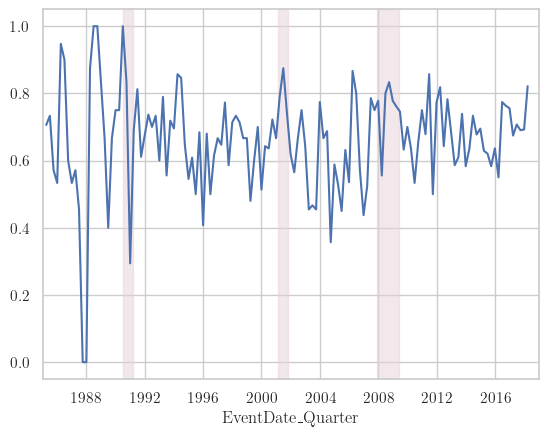

In [ ]:
ax = TempSample.groupby('EventDate_Quarter')['Flag_Negative'].mean().sort_index().plot()
MyGR.NBER_RecessionBar(ax)
ax.set_xlim(datetime.date(1985, 1, 1), datetime.date(2019, 1, 1))

In [ ]:
DataForPlot = pd.concat(DataDict, axis=1).sort_index()

In [ ]:
TempTab = DataForPlot.mean().rename('Mean')
TempTab 

AccAbRet_Avg                     -2.765506
AccAbRet_WAvg                    -3.045448
AccAbRet_Avg_Negative            -6.559619
AccAbRet_WAvg_Negative           -7.114637
AccAbRet_Avg_BelowAvg            -8.769419
AccAbRet_WAvg_BelowAvg           -9.384294
AccAbRet_Avg_AboveAvgExtShare    -3.379030
AccAbRet_WAvg_AboveAvgExtShare   -3.391939
Name: Mean, dtype: float64

In [ ]:
TempTab.to_latex(OutputFolder+'AvgAbRet_AcrossTime.tex', float_format="%.3g", escape=True)

<Axes: xlabel='EventDate_Quarter'>

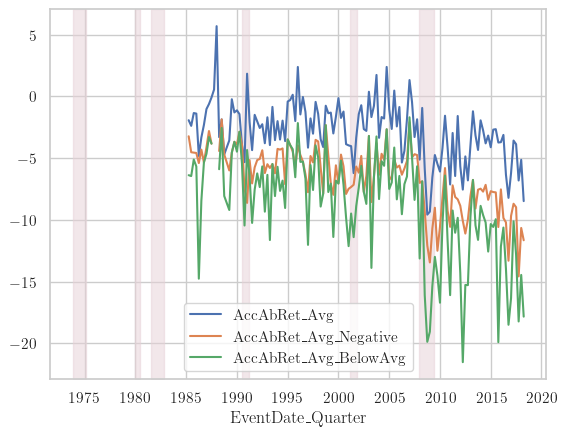

In [ ]:
DataForPlot[['AccAbRet_Avg', 'AccAbRet_Avg_Negative', 'AccAbRet_Avg_BelowAvg']].plot()
MyGR.NBER_RecessionBar(plt.gca())

<Axes: xlabel='EventDate_Quarter'>

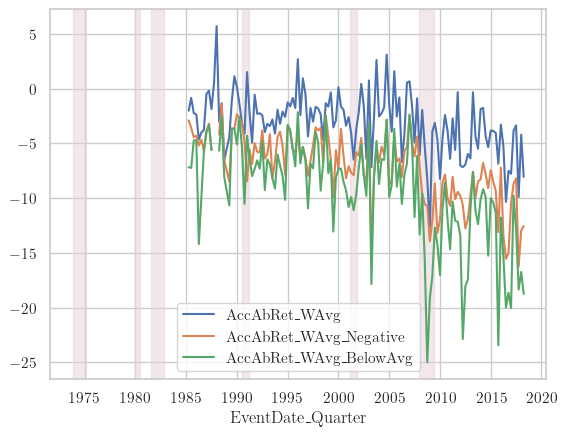

In [ ]:
DataForPlot[['AccAbRet_WAvg', 'AccAbRet_WAvg_Negative', 'AccAbRet_WAvg_BelowAvg']].plot()
MyGR.NBER_RecessionBar(plt.gca())

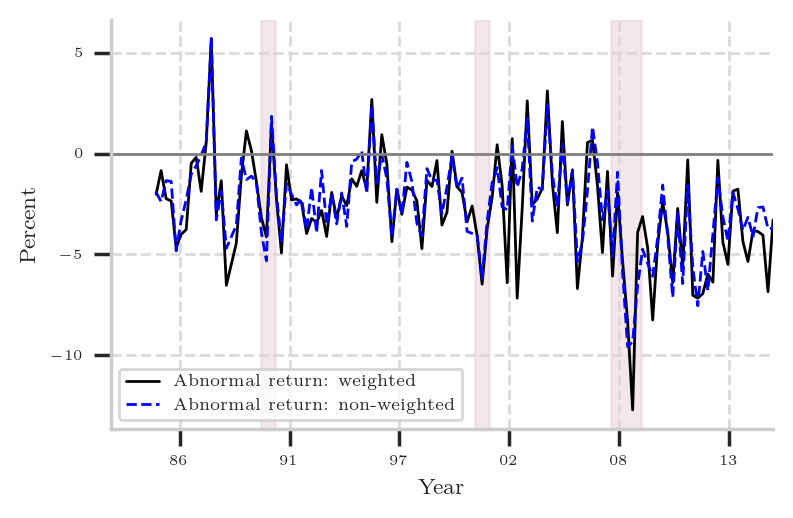

In [ ]:
Fig = MyGR.Setup_Fig()
ax = Fig.add_subplot(1,1,1)
MyGR.Line(Width=1).Plot(DataForPlot.index, DataForPlot['AccAbRet_WAvg'], ax=ax, Label="Abnormal return: weighted")
MyGR.Line(Color="Blue", Style="dashed", Width=1).Plot(DataForPlot.index, DataForPlot['AccAbRet_Avg'], ax=ax, Label="Abnormal return: non-weighted")
ax.set_xlim([datetime.date(1983,1,1),datetime.date(2015,12,31)])
ax.set_ylabel('Percent', fontsize=8) 
ax.set_xlabel('Year', fontsize=8)
ax.tick_params(axis='both', labelsize=5)
MyGR.NBER_RecessionBar(ax)
MyGR.Setup_Ax(ax, XDateFlag=True, XTickNbins=10)
plt.legend(loc='lower left', fontsize=6)

plt.tight_layout()

plt.savefig(OutputFolder+'AccAbRet_BusinessCycle_WeightedByShare.eps', format='eps', dpi=1000)

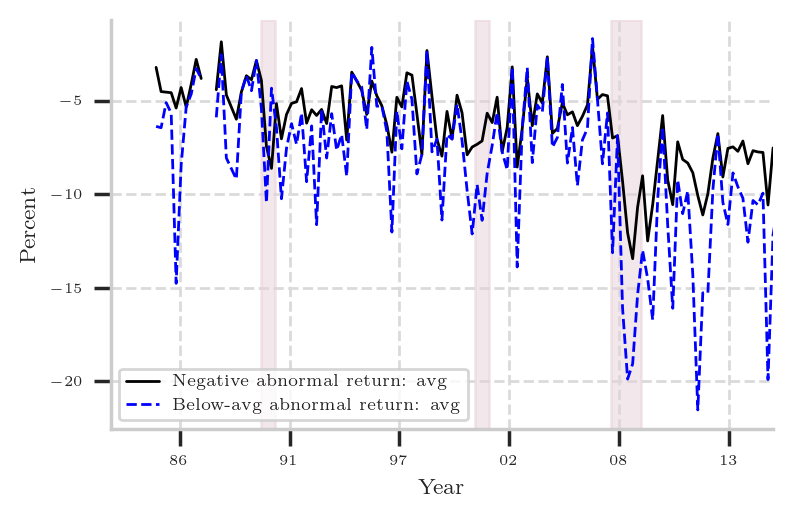

In [ ]:
Fig = MyGR.Setup_Fig()
ax = Fig.add_subplot(1,1,1)
MyGR.Line(Width=1).Plot(DataForPlot.index, DataForPlot['AccAbRet_Avg_Negative'], ax=ax, Label="Negative abnormal return: avg")
MyGR.Line(Color="Blue", Style="dashed", Width=1).Plot(DataForPlot.index, DataForPlot['AccAbRet_Avg_BelowAvg'], ax=ax, Label="Below-avg abnormal return: avg")
ax.set_xlim([datetime.date(1983,1,1),datetime.date(2015,12,31)])
ax.set_ylabel('Percent', fontsize=8) 
ax.set_xlabel('Year', fontsize=8)
ax.tick_params(axis='both', labelsize=5)
MyGR.NBER_RecessionBar(ax)
MyGR.Setup_Ax(ax, XDateFlag=True, XTickNbins=10)
plt.legend(loc='lower left', fontsize=6)

plt.tight_layout()

plt.savefig(OutputFolder+'AccAbRet_BusinessCycle_AvgLeftTail.eps', format='eps', dpi=1000)

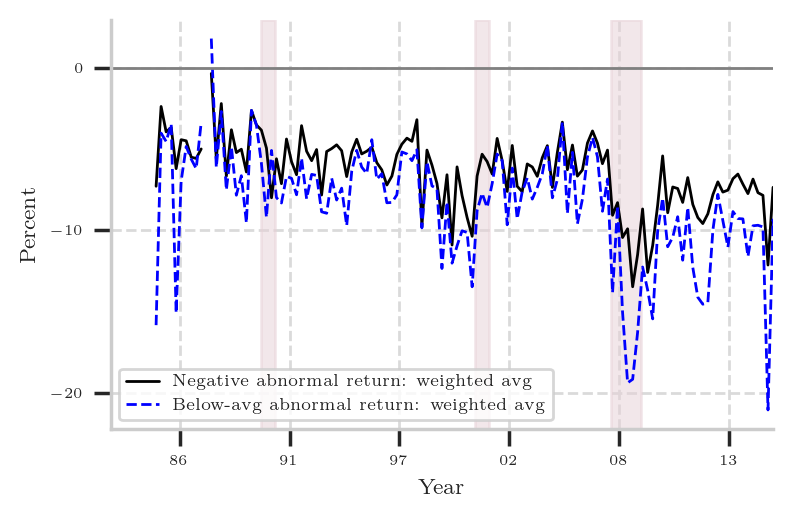

In [ ]:
Fig = MyGR.Setup_Fig()
ax = Fig.add_subplot(1,1,1)
MyGR.Line(Width=1).Plot(DataForPlot.index, DataForPlot['AccAbRet_WAvg_Negative'], ax=ax, Label="Negative abnormal return: weighted avg")
MyGR.Line(Color="Blue", Style="dashed", Width=1).Plot(DataForPlot.index, DataForPlot['AccAbRet_WAvg_BelowAvg'], ax=ax, Label="Below-avg abnormal return: weighted avg")
ax.set_xlim([datetime.date(1983,1,1),datetime.date(2015,12,31)])
ax.set_ylabel('Percent', fontsize=8) 
ax.set_xlabel('Year', fontsize=8)
ax.tick_params(axis='both', labelsize=5)
MyGR.NBER_RecessionBar(ax)
MyGR.Setup_Ax(ax, XDateFlag=True, XTickNbins=10)
plt.legend(loc='lower left', fontsize=6)

plt.tight_layout()